<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Name           249 non-null    object 
 1   Phone_Number   249 non-null    object 
 2   Experience     247 non-null    float64
 3   Qualification  248 non-null    object 
 4   University     249 non-null    object 
 5   Role           246 non-null    object 
 6   Cert           247 non-null    object 
 7   Date_Of_Birth  249 non-null    object 
 8   Salary         249 non-null    int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 17.6+ KB
None

Статистичний опис числових змінних:
       Experience         Salary
count  247.000000     249.000000
mean     3.441296   98186.746988
std      1.496471   23502.622217
min      1.000000   49500.000000
25%      2.000000   78500.000000
50%      4.000000  104500.000000
75%      5.000000  116500.000000
max      5.000000  141500.000000

Кількість

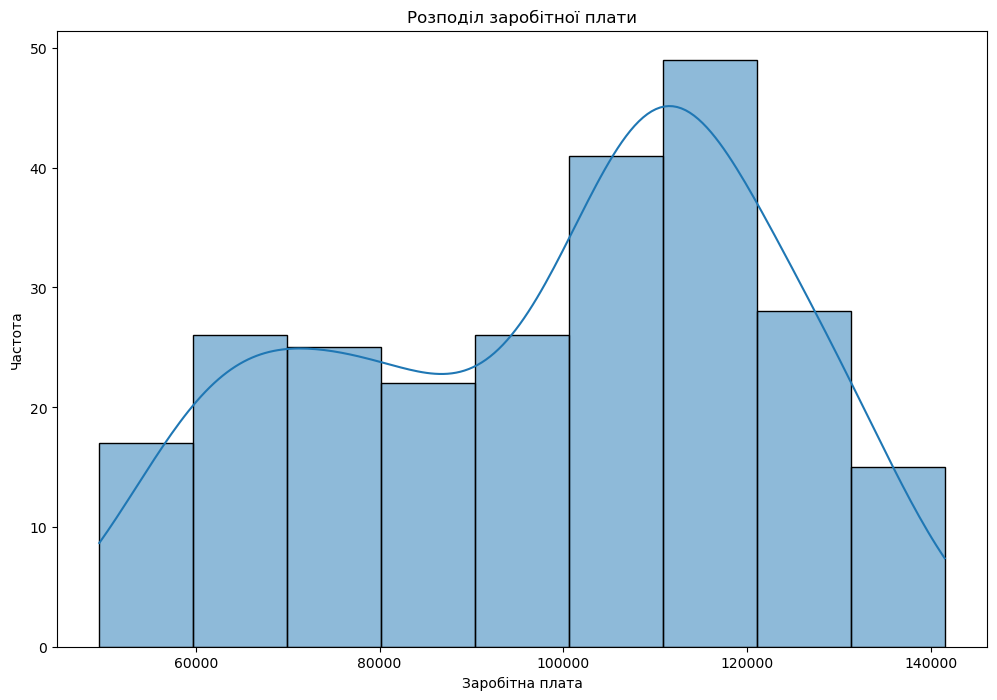


Validation MAPE: 4.08%


'\n- Даний код реалізує повний процес аналізу даних та створення моделі для прогнозування зарплати.\n- Для моделювання застосовано KNeighborsRegressor з попередньою обробкою даних (StandardScaler, PowerTransformer).\n- Target Encoding використано для обробки категоріальних змінних.\n- Точність моделі оцінюється за допомогою показника MAPE на валідаційних даних.\n'

In [64]:
import warnings
import pandas as pd
import category_encoders as ce
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Вимкнення попереджень
warnings.filterwarnings("ignore")

# Завантаження даних
train_data = pd.read_csv("./data/mod_04_hw_train_data.csv")
valid_data = pd.read_csv("./data/mod_04_hw_valid_data.csv")

# Первинний аналіз даних (EDA)
print(train_data.info())
print("\nСтатистичний опис числових змінних:")
print(train_data.describe())

# Перевірка наявності пропущених значень
print("\nКількість пропущених значень:")
print(train_data.isnull().sum())

# Візуалізація розподілу цільової змінної
plt.figure(figsize=(12, 8))
sns.histplot(train_data["Salary"], kde=True)
plt.title("Розподіл заробітної плати")
plt.xlabel("Заробітна плата")
plt.ylabel("Частота")
plt.show()

# Підготовка даних і видалення пропусків
train_data = train_data.dropna()

# Видалення непотрібних колонок та розділення на ознаки та цільову змінну
columns_to_drop = ["Name", "Phone_Number", "Date_Of_Birth"]
X = train_data.drop(columns=columns_to_drop, axis=1)
y = train_data["Salary"]

# Визначення категоріальних та числових ознак
cat_features = X.select_dtypes(include=["object"]).columns.tolist()
num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Створення трансформерів для числових і категоріальних даних
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", ce.TargetEncoder()),
    ]
)

# Об'єднання трансформацій за допомогою ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ]
)

# Побудова моделі на основі KNeighborsRegressor
model_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("power_transformer", PowerTransformer()),
        ("knn", KNeighborsRegressor()),
    ]
)

# Навчання моделі на тренувальних даних
model_pipeline.fit(X, y)

# Підготовка валідаційного набору
X_valid = valid_data.drop(columns=columns_to_drop, axis=1)
y_valid = valid_data["Salary"].dropna()

# Отримання прогнозів та оцінка точності
y_pred = model_pipeline.predict(X_valid)
mape = mean_absolute_percentage_error(y_valid, y_pred)
print(f"\nValidation MAPE: {mape:.2%}")

# Висновки

"""
- Даний код реалізує повний процес аналізу даних та створення моделі для прогнозування зарплати.
- Для моделювання застосовано KNeighborsRegressor з попередньою обробкою даних (StandardScaler, PowerTransformer).
- Target Encoding використано для обробки категоріальних змінних.
- Точність моделі оцінюється за допомогою показника MAPE на валідаційних даних.
"""